# **Deep Learning Project - Multiclass Classification**

---

## Table of Contents
1. [Imports](#Imports)  
2. [Load and prepare images](#load-and-prepare-images)
3. [Model Experimentation and Tuning](#model-experimentation-and-tuning)
    - [Data augmentation](#data-augmentation)
    - [Pre-trained models](#pre-trained-models)
    - [Transformations](#transformations)
    - [Adjust Class Weights](#adjust-class-weights)
    - [Hyperband Search](#hyperband-search)
4. [Evaluation of best 2 models](#evaluation-of-best-2-models)
    


   
----

# Imports

In [57]:
from functions import *

<module 'functions' from 'c:\\Users\\User\\Desktop\\Vasco\\DeepLearning\\functions.py'>

# Load and prepare images

In [58]:
# Load the cleaned dataset 
df_clean = pd.read_csv('df_clean.csv')

In [59]:
# Extract image paths and labels for multiclass classification 
image_paths = df_clean['path_to_image'].values
labels_multiclass = df_clean['Cancer Type'].values

In [60]:
np.unique(labels_multiclass)

array(['Adenosis', 'Ductal Carcinoma', 'Fibroadenoma',
       'Lobular Carcinoma', 'Mucinous Carcinoma', 'Papillary Carcinoma',
       'Phyllodes Tumor', 'Tubular Adenoma'], dtype=object)

In [61]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_multiclass, y_test_multiclass = train_test_split(
    image_paths, labels_multiclass, test_size=0.2, stratify=labels_multiclass, random_state=42)

# Further split the training set into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train_multiclass, y_val_multiclass = train_test_split(
    X_train, y_train_multiclass, test_size=0.2, stratify=y_train_multiclass, random_state=42)

# Print the number of samples in each array (Training, Validation, and Test)
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 5061
Validation samples: 1266
Test samples: 1582


In [62]:
# Check if the labels are imbalanced
print("\n Training label distribution:\n", pd.Series(y_train_multiclass).value_counts())
print("\n Validation label distribution:\n", pd.Series(y_val_multiclass).value_counts())
print("\n Test label distribution:\n", pd.Series(y_test_multiclass).value_counts())


 Training label distribution:
 Ductal Carcinoma       2208
Fibroadenoma            649
Mucinous Carcinoma      507
Lobular Carcinoma       401
Tubular Adenoma         364
Papillary Carcinoma     358
Phyllodes Tumor         290
Adenosis                284
Name: count, dtype: int64

 Validation label distribution:
 Ductal Carcinoma       553
Fibroadenoma           162
Mucinous Carcinoma     127
Lobular Carcinoma      100
Tubular Adenoma         91
Papillary Carcinoma     90
Phyllodes Tumor         72
Adenosis                71
Name: count, dtype: int64

 Test label distribution:
 Ductal Carcinoma       690
Fibroadenoma           203
Mucinous Carcinoma     158
Lobular Carcinoma      125
Tubular Adenoma        114
Papillary Carcinoma    112
Phyllodes Tumor         91
Adenosis                89
Name: count, dtype: int64


Given the class distribution across the training, validation, and test sets, we observe a clear imbalance among the categories, with Ductal Carcinoma being the most represented class and others, such as Adenosis and Phyllodes Tumor, having significantly fewer samples. To address this imbalance, we will adopt the F1 score as our primary evaluation metric on the test set.

In [ ]:
# Load the images
X_train_images = load_images(X_train)
X_val_images = load_images(X_val)
X_test_images = load_images(X_test)

In [64]:
print(f"Training images shape: {X_train_images.shape}")
print(f"Validation images shape: {X_val_images.shape}")
print(f"Test images shape: {X_test_images.shape}")

Training images shape: (5061, 150, 150, 3)
Validation images shape: (1266, 150, 150, 3)
Test images shape: (1582, 150, 150, 3)


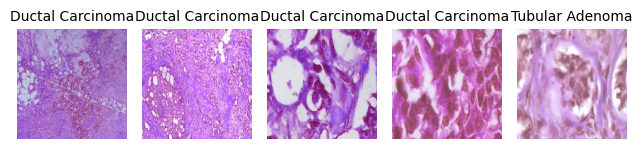

In [65]:
# Display the first 5 images from the training set along with their corresponding labels
for i in range(5):  
    plt.subplot(1, 5, i+1)  
    plt.imshow(X_train_images[i])  
    plt.axis('off')  
    plt.title(y_train_multiclass[i], fontsize=10)  

plt.tight_layout() 
plt.show()

In [66]:
# Define a mapping from class names to numerical labels
label_mapping = {
    'Adenosis': 0,
    'Ductal Carcinoma': 1,
    'Fibroadenoma': 2,
    'Lobular Carcinoma': 3,
    'Mucinous Carcinoma': 4,
    'Papillary Carcinoma': 5,
    'Phyllodes Tumor': 6,
    'Tubular Adenoma': 7
}

# Convert the training, validation, and test labels to numeric format
y_train_multiclass = np.array([label_mapping[label] for label in y_train_multiclass])
y_val_multiclass = np.array([label_mapping[label] for label in y_val_multiclass])
y_test_multiclass = np.array([label_mapping[label] for label in y_test_multiclass])

# Print the first 10 encoded labels for each array to verify the transformation
print("Encoded y_train:", y_train_multiclass[:10])  
print("Encoded y_val:", y_val_multiclass[:10]) 
print("Encoded y_test:", y_test_multiclass[:10])  

Encoded y_train: [1 1 1 1 7 0 0 6 4 7]
Encoded y_val: [1 5 1 2 2 1 1 3 3 4]
Encoded y_test: [4 1 1 1 1 4 1 1 1 6]


# Model Experimentation and Tuning
In this section, we will begin by testing a small and simple model as a baseline, and based on the results it provides, we will improve the model further.

We define the EarlyStopping callback here, which will be used for all models moving forward.

In [67]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [ ]:
# Initialize the Sequential model
model = Sequential()

# Add a convolutional layer followed by max pooling
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

# Add another convolutional layer followed by max pooling
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps into a 1D vector
model.add(Flatten())

# Add a dense layer
model.add(Dense(64, activation='relu'))

# Add the output layer for multiclass classification
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model 
history = model.fit(
    X_train_images,
    y_train_multiclass,
    validation_data=(X_val_images, y_val_multiclass),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
159/159 [==============================] - 32s 182ms/step - loss: 1.7192 - accuracy: 0.4600 - val_loss: 1.5432 - val_accuracy: 0.5087
Epoch 2/30
159/159 [==============================] - 26s 165ms/step - loss: 1.5684 - accuracy: 0.4861 - val_loss: 1.5764 - val_accuracy: 0.4700
Epoch 3/30
159/159 [==============================] - 21s 134ms/step - loss: 1.5674 - accuracy: 0.4711 - val_loss: 1.4391 - val_accuracy: 0.5047
Epoch 4/30
159/159 [==============================] - 27s 172ms/step - loss: 1.4539 - accuracy: 0.5052 - val_loss: 1.4099 - val_accuracy: 0.5095
Epoch 5/30
159/159 [==============================] - 28s 173ms/step - loss: 1.3796 - accuracy: 0.5206 - val_loss: 1.3660 - val_accuracy: 0.5237
Epoch 6/30
159/159 [==============================] - 20s 127ms/step - loss: 1.3180 - accuracy: 0.5331 - val_loss: 1.3542 - val_accuracy: 0.5253
Epoch 7/30
159/159 [==============================] - 21s 131ms/step - loss: 1.2847 - accuracy: 0.5479 - val_loss: 1.3625 - val_ac

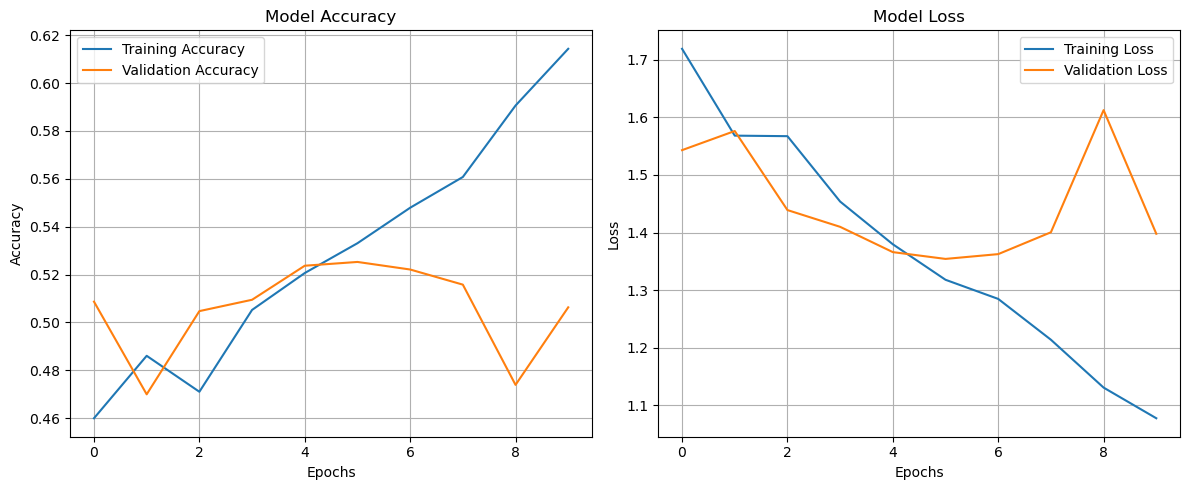

In [ ]:
plot_training_history(history)

The training accuracy increases steadily, while the training loss decreases, indicating that the model is learning from the training data. However, the validation accuracy fluctuates and does not show consistent improvement, while the validation loss exhibits irregular behavior and  increasing at certain points.

This suggests that the model struggles to generalize well to unseen data, which is expected in a multi-class classification problem with imbalanced class distributions and high complexity. Achieving satisfactory results in this scenario is particularly challenging.

We will now add dropout in the convolutional layers to try to prevent overfitting.

In [ ]:
# Initialize the Sequential model
model = Sequential()

# Convolutional layers with max pooling and dropout
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Flatten layer
model.add(Flatten())

# Fully connected layers with dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    X_train_images,
    y_train_multiclass,
    validation_data=(X_val_images, y_val_multiclass),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
159/159 [==============================] - 39s 218ms/step - loss: 2.0718 - accuracy: 0.4080 - val_loss: 1.8734 - val_accuracy: 0.4471
Epoch 2/30
159/159 [==============================] - 28s 177ms/step - loss: 1.6663 - accuracy: 0.4586 - val_loss: 1.7693 - val_accuracy: 0.5055
Epoch 3/30
159/159 [==============================] - 28s 176ms/step - loss: 1.6169 - accuracy: 0.4744 - val_loss: 1.6542 - val_accuracy: 0.4605
Epoch 4/30
159/159 [==============================] - 32s 202ms/step - loss: 1.5811 - accuracy: 0.4880 - val_loss: 1.6644 - val_accuracy: 0.4921
Epoch 5/30
159/159 [==============================] - 30s 186ms/step - loss: 1.5784 - accuracy: 0.4831 - val_loss: 1.6559 - val_accuracy: 0.4874
Epoch 6/30
159/159 [==============================] - 29s 183ms/step - loss: 1.5474 - accuracy: 0.4888 - val_loss: 1.6498 - val_accuracy: 0.5000
Epoch 7/30
159/159 [==============================] - 33s 210ms/step - loss: 1.5205 - accuracy: 0.4882 - val_loss: 1.5484 - val_ac

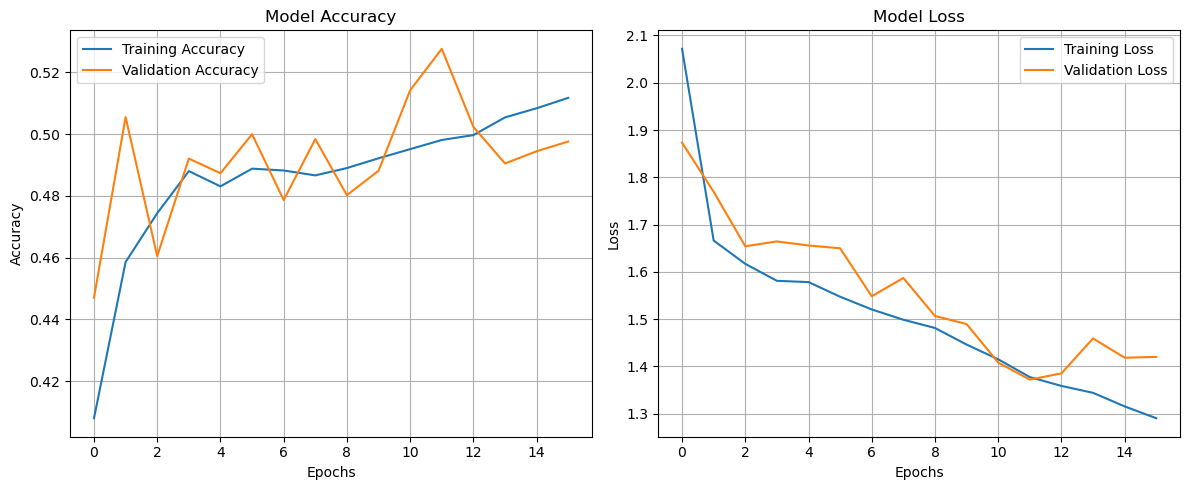

In [ ]:
plot_training_history(history)

Let's try just changing the optimizer.

In [ ]:
# Initialize the Sequential model
model = Sequential()

# Convolutional layers with max pooling and dropout
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    X_train_images,
    y_train_multiclass,
    validation_data=(X_val_images, y_val_multiclass),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
159/159 [==============================] - 37s 213ms/step - loss: 3.1234 - accuracy: 0.4070 - val_loss: 2.0319 - val_accuracy: 0.4368
Epoch 2/30
159/159 [==============================] - 33s 209ms/step - loss: 1.7125 - accuracy: 0.4428 - val_loss: 2.0107 - val_accuracy: 0.4455
Epoch 3/30
159/159 [==============================] - 30s 191ms/step - loss: 1.6502 - accuracy: 0.4602 - val_loss: 1.9500 - val_accuracy: 0.4471
Epoch 4/30
159/159 [==============================] - 33s 206ms/step - loss: 1.6173 - accuracy: 0.4784 - val_loss: 1.9275 - val_accuracy: 0.4376
Epoch 5/30
159/159 [==============================] - 33s 208ms/step - loss: 1.5912 - accuracy: 0.4837 - val_loss: 1.7021 - val_accuracy: 0.5079
Epoch 6/30
159/159 [==============================] - 35s 217ms/step - loss: 1.5528 - accuracy: 0.4882 - val_loss: 1.6807 - val_accuracy: 0.4423
Epoch 7/30
159/159 [==============================] - 28s 175ms/step - loss: 1.5199 - accuracy: 0.4936 - val_loss: 1.6290 - val_ac

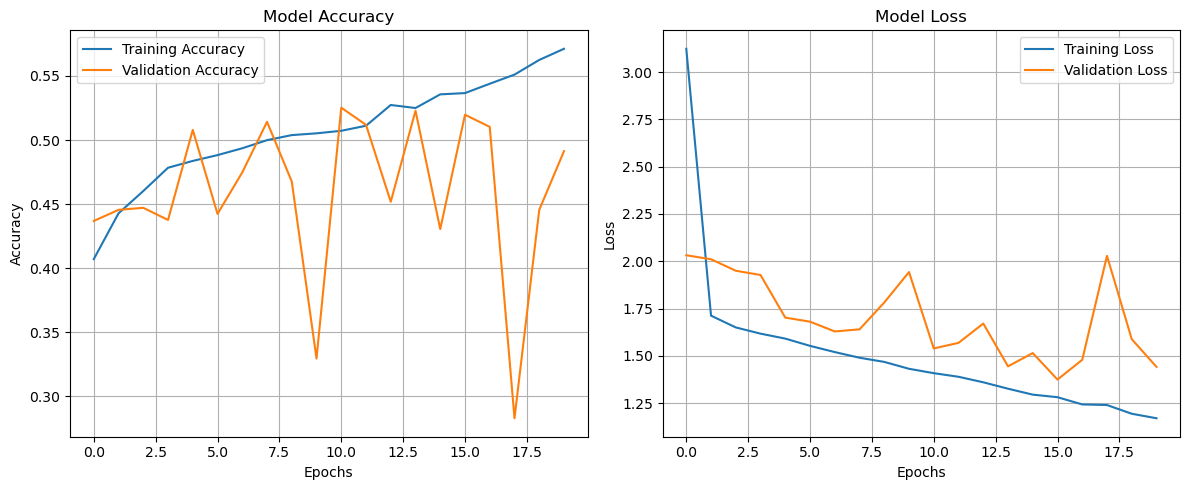

In [ ]:
plot_training_history(history)

With the RMSprop optimizer, we achieved worse results. Lets add complexity just on convolutional layers.

In [ ]:
# Initialize the Sequential model
model = Sequential()

# Add a convolutional layer followed by max pooling and dropout
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Add a convolutional layer followed by max pooling and dropout
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Add a convolutional layer followed by max pooling and dropout
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

# Add a convolutional layer followed just by
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


# Flatten layer
model.add(Flatten())

# Fully connected layers with dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    X_train_images,
    y_train_multiclass,
    validation_data=(X_val_images, y_val_multiclass),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
159/159 [==============================] - 48s 277ms/step - loss: 1.7214 - accuracy: 0.4521 - val_loss: 1.7388 - val_accuracy: 0.5047
Epoch 2/30
159/159 [==============================] - 37s 232ms/step - loss: 1.5889 - accuracy: 0.4865 - val_loss: 1.5900 - val_accuracy: 0.5016
Epoch 3/30
159/159 [==============================] - 35s 221ms/step - loss: 1.5640 - accuracy: 0.4950 - val_loss: 1.6127 - val_accuracy: 0.4826
Epoch 4/30
159/159 [==============================] - 38s 239ms/step - loss: 1.5495 - accuracy: 0.5005 - val_loss: 1.5251 - val_accuracy: 0.5118
Epoch 5/30
159/159 [==============================] - 33s 204ms/step - loss: 1.5171 - accuracy: 0.5050 - val_loss: 1.5598 - val_accuracy: 0.5142
Epoch 6/30
159/159 [==============================] - 35s 221ms/step - loss: 1.4985 - accuracy: 0.5015 - val_loss: 1.4691 - val_accuracy: 0.5150
Epoch 7/30
159/159 [==============================] - 33s 210ms/step - loss: 1.4719 - accuracy: 0.5116 - val_loss: 1.5120 - val_ac

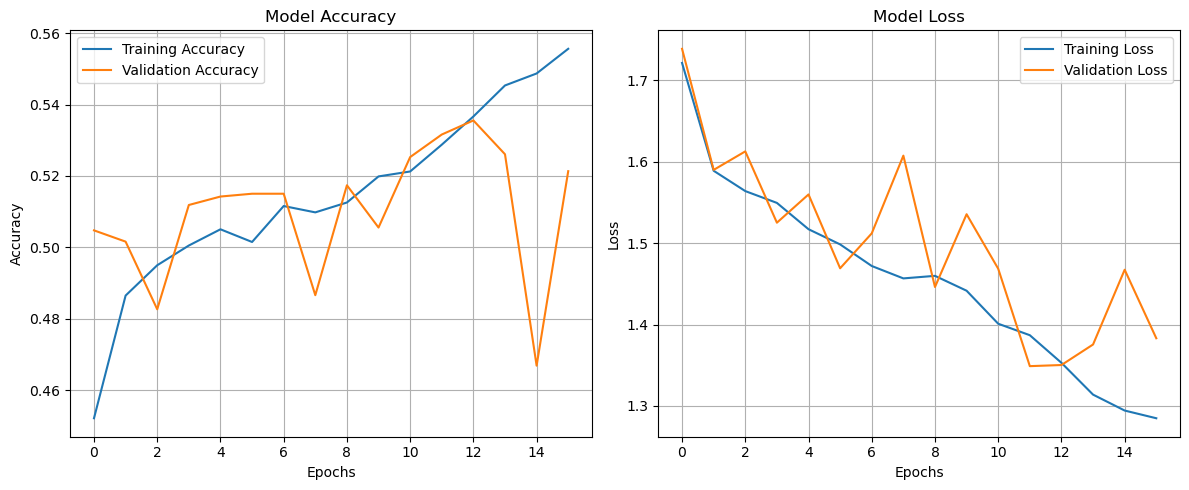

In [ ]:
plot_training_history(history)

The results were more fluctuating but overall better. Now lets try the same model with more complex dense layers.

In [ ]:
# Initialize the Sequential model
model = Sequential()

# Add a convolutional layer followed by max pooling and dropout
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Add a convolutional layer followed by max pooling and dropout
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Add a convolutional layer followed by max pooling and dropout
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

# Add a convolutional layer followed just by
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


# Flatten layer
model.add(Flatten())

# Fully connected layers with dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    X_train_images,
    y_train_multiclass,
    validation_data=(X_val_images, y_val_multiclass),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
159/159 [==============================] - 40s 237ms/step - loss: 1.7353 - accuracy: 0.4420 - val_loss: 1.7077 - val_accuracy: 0.5032
Epoch 2/30
159/159 [==============================] - 33s 210ms/step - loss: 1.6193 - accuracy: 0.4813 - val_loss: 1.7169 - val_accuracy: 0.4913
Epoch 3/30
159/159 [==============================] - 33s 208ms/step - loss: 1.5605 - accuracy: 0.4979 - val_loss: 1.6327 - val_accuracy: 0.4897
Epoch 4/30
159/159 [==============================] - 34s 217ms/step - loss: 1.5517 - accuracy: 0.4940 - val_loss: 1.6890 - val_accuracy: 0.5008
Epoch 5/30
159/159 [==============================] - 34s 216ms/step - loss: 1.5220 - accuracy: 0.5039 - val_loss: 1.5731 - val_accuracy: 0.4763
Epoch 6/30
159/159 [==============================] - 32s 204ms/step - loss: 1.5201 - accuracy: 0.4989 - val_loss: 1.6204 - val_accuracy: 0.5055
Epoch 7/30
159/159 [==============================] - 32s 204ms/step - loss: 1.4877 - accuracy: 0.5086 - val_loss: 1.5646 - val_ac

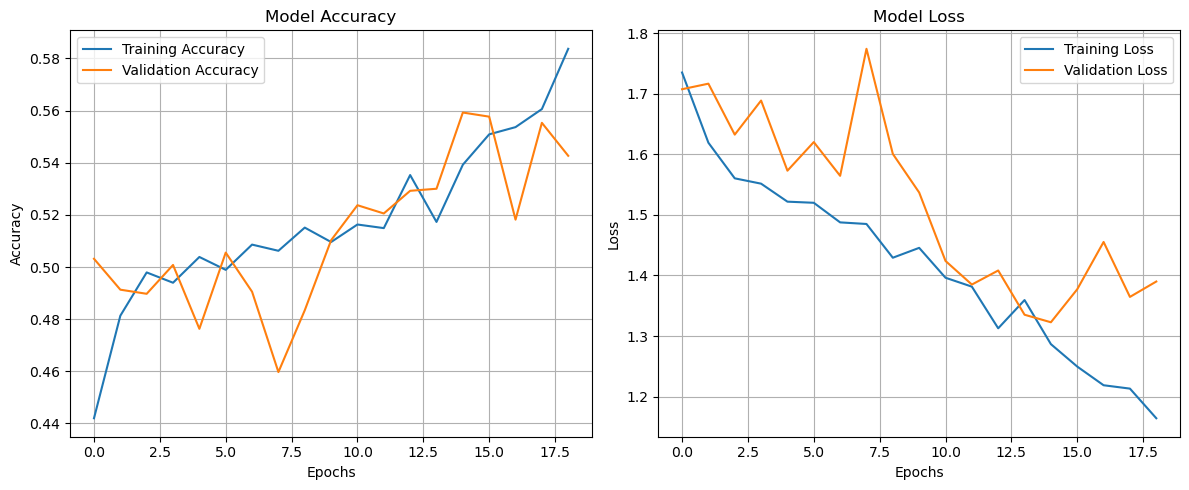

In [ ]:
plot_training_history(history)

Consideringthat this is the best model so far, we will apply an image data generator to its architecture.

# Data Augmentation

In [ ]:
# Define the model architecture
model1_multi = Sequential()

model1_multi.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model1_multi.add(MaxPooling2D((2, 2)))
model1_multi.add(Dropout(0.4))

model1_multi.add(Conv2D(32, (3, 3), activation='relu'))
model1_multi.add(MaxPooling2D((2, 2)))
model1_multi.add(Dropout(0.2))

model1_multi.add(Conv2D(32, (3, 3), activation='relu'))
model1_multi.add(MaxPooling2D((2, 2)))
model1_multi.add(Dropout(0.1))

model1_multi.add(Conv2D(64, (3, 3), activation='relu'))
model1_multi.add(MaxPooling2D((2, 2)))

model1_multi.add(Flatten())
model1_multi.add(Dense(64, activation='relu'))
model1_multi.add(Dropout(0.2))

model1_multi.add(Dense(128, activation='relu'))
model1_multi.add(Dropout(0.2))

model1_multi.add(Dense(8, activation='softmax'))

model1_multi.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# ImageDataGenerator for augmenting training data
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()  

train_generator = train_datagen.flow(
    X_train_images, y_train_multiclass,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val_images, y_val_multiclass,
    batch_size=32
)

In [ ]:
# Train the model
history = model1_multi.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_val) // 32,
    callbacks=[early_stopping]
)

Epoch 1/50
158/158 [==============================] - 88s 542ms/step - loss: 1.6892 - accuracy: 0.4478 - val_loss: 1.6541 - val_accuracy: 0.4824
Epoch 2/50
158/158 [==============================] - 87s 553ms/step - loss: 1.6016 - accuracy: 0.4820 - val_loss: 1.6104 - val_accuracy: 0.5040
Epoch 3/50
158/158 [==============================] - 88s 554ms/step - loss: 1.5438 - accuracy: 0.5041 - val_loss: 1.5434 - val_accuracy: 0.5152
Epoch 4/50
158/158 [==============================] - 91s 572ms/step - loss: 1.5261 - accuracy: 0.5083 - val_loss: 1.4743 - val_accuracy: 0.5184
Epoch 5/50
158/158 [==============================] - 88s 559ms/step - loss: 1.5210 - accuracy: 0.5081 - val_loss: 1.4701 - val_accuracy: 0.5224
Epoch 6/50
158/158 [==============================] - 88s 555ms/step - loss: 1.4893 - accuracy: 0.5083 - val_loss: 1.4450 - val_accuracy: 0.5176
Epoch 7/50
158/158 [==============================] - 88s 555ms/step - loss: 1.4731 - accuracy: 0.5090 - val_loss: 1.4596 - val_ac

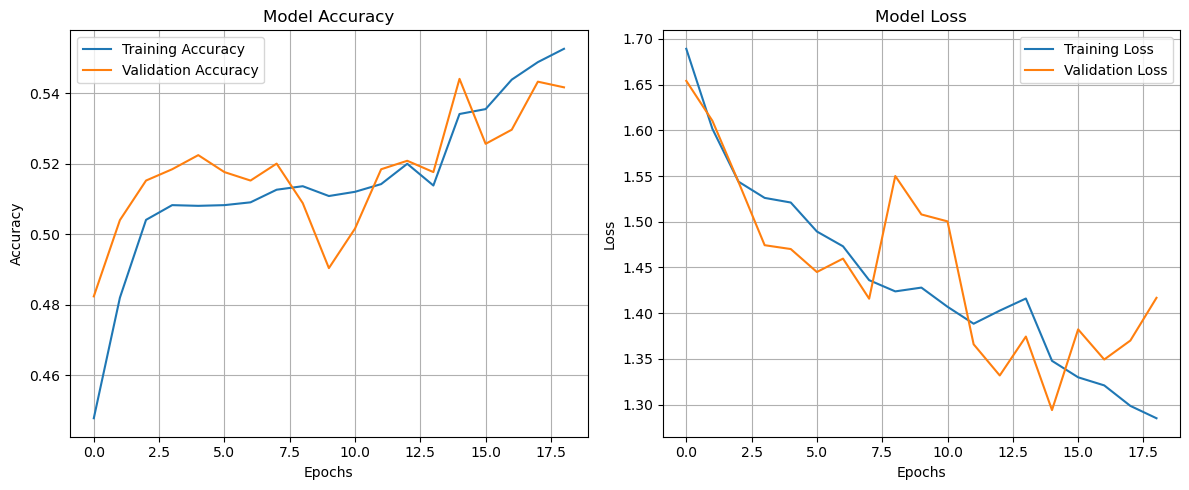

In [15]:
plot_training_history(history)

In [ ]:
# Save the model
model1_multi.save('saved_models/model1_multi.h5')

# Pre-trained models

In [31]:
model_mobilenet = create_pretrained_model('MobileNetV2', input_shape=(150, 150, 3), num_classes=8)
model_nasnetmobile = create_pretrained_model('NasNetMobile', input_shape=(150, 150, 3), num_classes=8)
model_inceptionv3 = create_pretrained_model('InceptionV3', input_shape=(150, 150, 3), num_classes=8)

87910968/87910968 [==============================] - 2s 0us/step


In [32]:
# Train MobileNetV2 model
history_mobilenet = model_mobilenet.fit(
    X_train_images,  
    y_train_multiclass,        
    validation_data=(X_val_images, y_val_multiclass),  
    epochs=30,       
    batch_size=64,   
    verbose=1,
    callbacks=[early_stopping]        
)

Epoch 1/30
80/80 [==============================] - 180s 2s/step - loss: 1.6582 - accuracy: 0.4394 - val_loss: 1.6922 - val_accuracy: 0.3902
Epoch 2/30
80/80 [==============================] - 160s 2s/step - loss: 1.3678 - accuracy: 0.5078 - val_loss: 1.3492 - val_accuracy: 0.5111
Epoch 3/30
80/80 [==============================] - 159s 2s/step - loss: 1.2142 - accuracy: 0.5606 - val_loss: 1.2434 - val_accuracy: 0.5466
Epoch 4/30
80/80 [==============================] - 162s 2s/step - loss: 1.1136 - accuracy: 0.5997 - val_loss: 1.3638 - val_accuracy: 0.5340
Epoch 5/30
80/80 [==============================] - 157s 2s/step - loss: 1.0383 - accuracy: 0.6277 - val_loss: 1.3042 - val_accuracy: 0.5150
Epoch 6/30
80/80 [==============================] - 148s 2s/step - loss: 0.9553 - accuracy: 0.6578 - val_loss: 1.2205 - val_accuracy: 0.5766
Epoch 7/30
80/80 [==============================] - 149s 2s/step - loss: 0.8934 - accuracy: 0.6720 - val_loss: 1.3647 - val_accuracy: 0.5592
Epoch 8/30
80

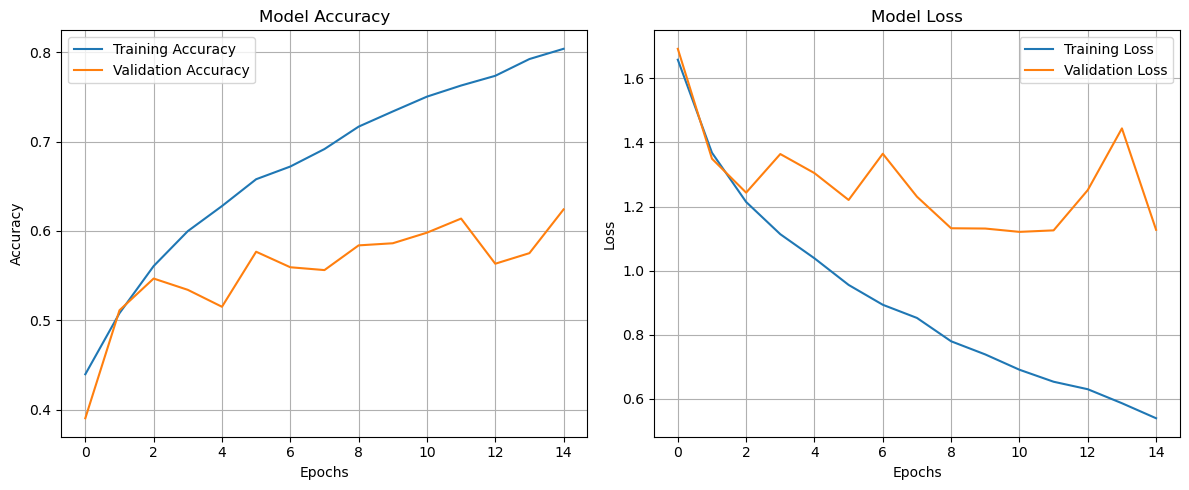

In [33]:
plot_training_history(history_mobilenet)

In [ ]:
# Save MobileNetV2 model
model_mobilenet.save('saved_models/net_multiclass.h5')

In [34]:
# Train NasNetMobile model
history_nasnetmobile = model_nasnetmobile.fit(
    X_train_images,  
    y_train_multiclass,        
    validation_data=(X_val_images, y_val_multiclass),  
    epochs=30,       
    batch_size=64,   
    verbose=1,
    callbacks=[early_stopping]        
)

Epoch 1/30
80/80 [==============================] - 272s 3s/step - loss: 1.5871 - accuracy: 0.4707 - val_loss: 1.4474 - val_accuracy: 0.5039
Epoch 2/30
80/80 [==============================] - 237s 3s/step - loss: 1.3222 - accuracy: 0.5339 - val_loss: 1.3653 - val_accuracy: 0.4992
Epoch 3/30
80/80 [==============================] - 245s 3s/step - loss: 1.1954 - accuracy: 0.5748 - val_loss: 1.2653 - val_accuracy: 0.5600
Epoch 4/30
80/80 [==============================] - 249s 3s/step - loss: 1.1030 - accuracy: 0.6013 - val_loss: 1.2342 - val_accuracy: 0.5521
Epoch 5/30
80/80 [==============================] - 267s 3s/step - loss: 1.0211 - accuracy: 0.6337 - val_loss: 1.3091 - val_accuracy: 0.5442
Epoch 6/30
80/80 [==============================] - 287s 4s/step - loss: 0.9660 - accuracy: 0.6515 - val_loss: 1.3828 - val_accuracy: 0.5039
Epoch 7/30
80/80 [==============================] - 287s 4s/step - loss: 0.8978 - accuracy: 0.6738 - val_loss: 1.1014 - val_accuracy: 0.5924
Epoch 8/30
80

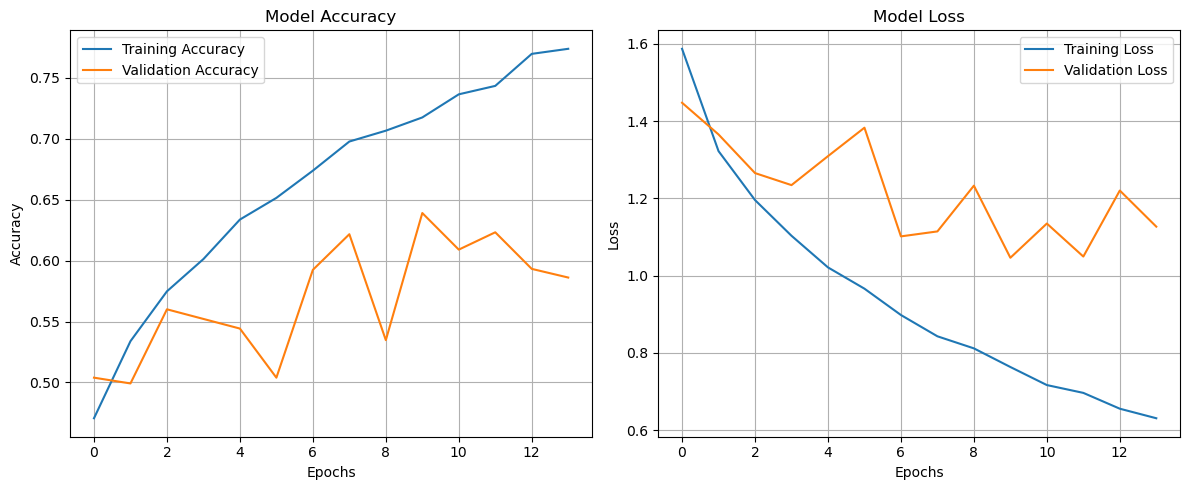

In [35]:
plot_training_history(history_nasnetmobile)

In [ ]:
# Save NasNetMobile model
model_nasnetmobile.save('saved_models/model_nasnetmobile_multiclass.h5')

In [36]:
# Train InceptionV3 model
history_inceptionv3 = model_inceptionv3.fit(
    X_train_images,  
    y_train_multiclass,        
    validation_data=(X_val_images, y_val_multiclass),  
    epochs=30,       
    batch_size=64,   
    verbose=1,
    callbacks=[early_stopping]        
)

Epoch 1/30
80/80 [==============================] - 333s 4s/step - loss: 1.7713 - accuracy: 0.4398 - val_loss: 1.5732 - val_accuracy: 0.4897
Epoch 2/30
80/80 [==============================] - 319s 4s/step - loss: 1.4629 - accuracy: 0.4958 - val_loss: 1.6953 - val_accuracy: 0.4795
Epoch 3/30
80/80 [==============================] - 315s 4s/step - loss: 1.3564 - accuracy: 0.5327 - val_loss: 1.4544 - val_accuracy: 0.5000
Epoch 4/30
80/80 [==============================] - 311s 4s/step - loss: 1.2586 - accuracy: 0.5489 - val_loss: 1.5105 - val_accuracy: 0.4929
Epoch 5/30
80/80 [==============================] - 313s 4s/step - loss: 1.1896 - accuracy: 0.5702 - val_loss: 1.2874 - val_accuracy: 0.5379
Epoch 6/30
80/80 [==============================] - 315s 4s/step - loss: 1.1197 - accuracy: 0.5971 - val_loss: 1.6141 - val_accuracy: 0.4107
Epoch 7/30
80/80 [==============================] - 316s 4s/step - loss: 1.0816 - accuracy: 0.6074 - val_loss: 1.2599 - val_accuracy: 0.5656
Epoch 8/30
80

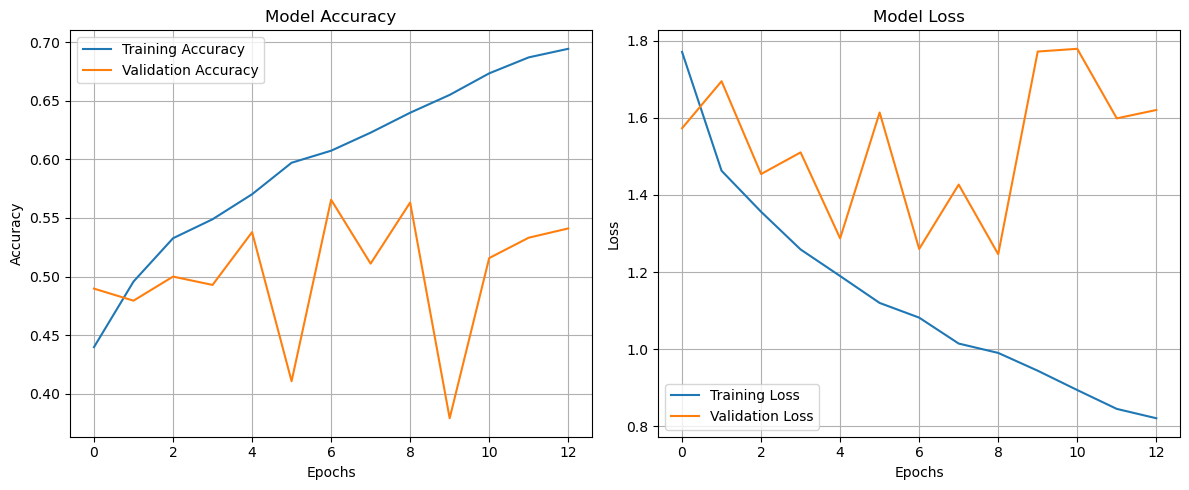

In [37]:
plot_training_history(history_inceptionv3)

In [ ]:
model_inceptionv3.save('saved_models/model_inceptionv3_multiclass.h5')

Pre-trained models did not perform well, so we will explore other approaches to improve the results.

# Transformations

Now, we will perform some transformations on our best model so far. The transformations: brightness adjustment, contrast adjustment, saturation adjustment, and noise addition are designed to improve the model's robustness and generalization.

Let's see what each transformation does on the images.

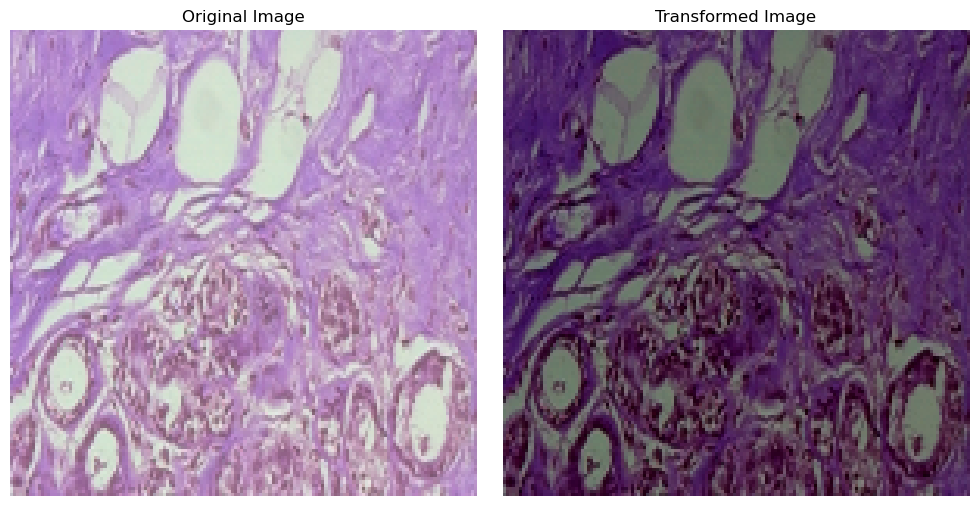

In [24]:
plot_diferent_images(X_train_images, 5, adjust_brightness, -0.4)

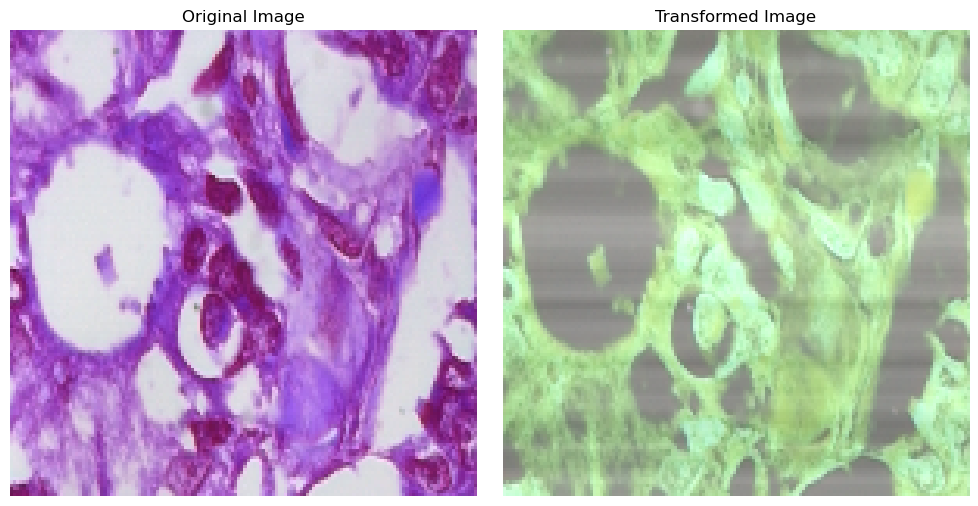

In [26]:
plot_diferent_images(X_train_images, 2, adjust_contrast, -0.6)

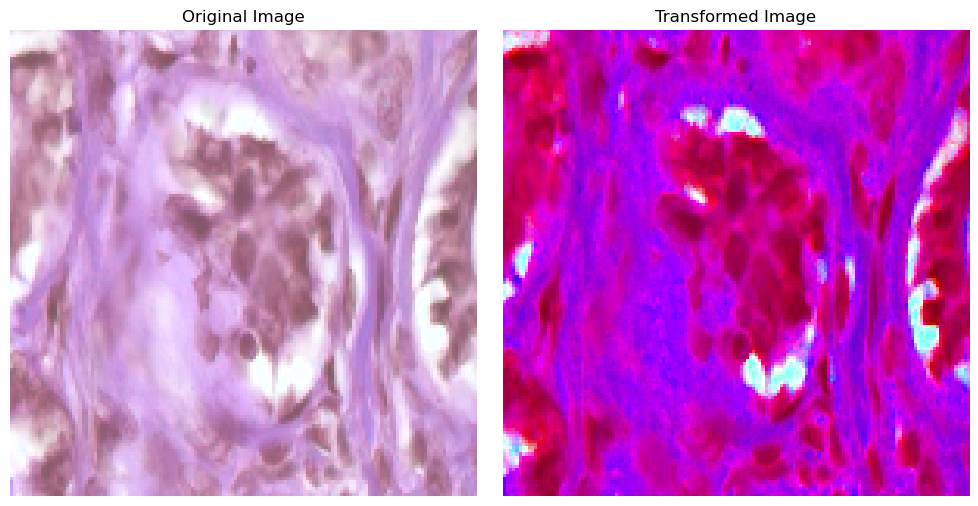

In [ ]:
plot_diferent_images(X_train_images, 4, adjust_saturation, 10)

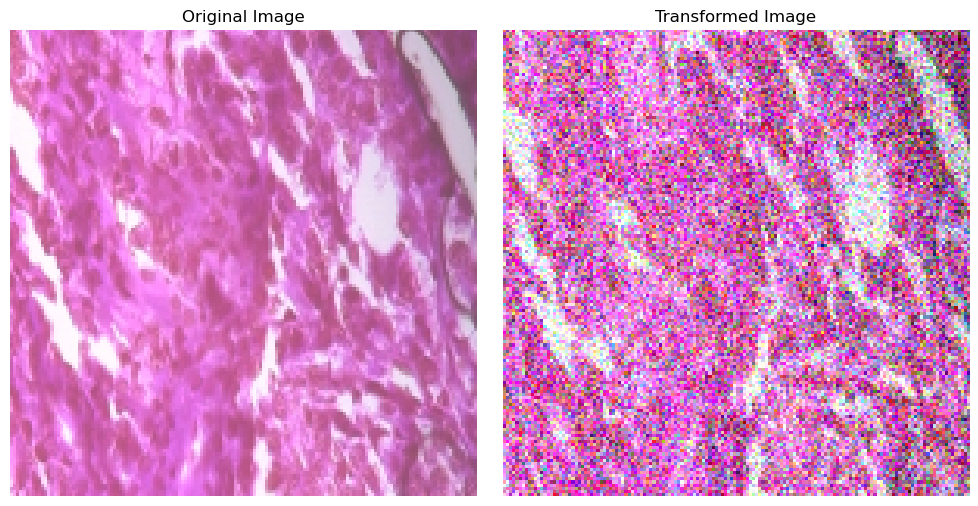

In [28]:
plot_diferent_images(X_train_images, 10, add_noise, 0.2)

In [18]:
history = train_with_transformation(X_train_images, y_train_multiclass, X_val_images, y_val_multiclass, transformation_name=adjust_brightness,transformation_label='adjust_brightness', factor=-0.4)

Epoch 1/50
101/101 [==============================] - 68s 658ms/step - loss: 1.6686 - accuracy: 0.4532 - val_loss: 1.6738 - val_accuracy: 0.4730
Epoch 2/50
101/101 [==============================] - 65s 643ms/step - loss: 1.5793 - accuracy: 0.4969 - val_loss: 1.6394 - val_accuracy: 0.4950
Epoch 3/50
101/101 [==============================] - 65s 638ms/step - loss: 1.5092 - accuracy: 0.5058 - val_loss: 1.5641 - val_accuracy: 0.5240
Epoch 4/50
101/101 [==============================] - 66s 649ms/step - loss: 1.5078 - accuracy: 0.5136 - val_loss: 1.5586 - val_accuracy: 0.4930
Epoch 5/50
101/101 [==============================] - 64s 630ms/step - loss: 1.4798 - accuracy: 0.5128 - val_loss: 1.6003 - val_accuracy: 0.4910
Epoch 6/50
101/101 [==============================] - 64s 629ms/step - loss: 1.4672 - accuracy: 0.5168 - val_loss: 1.4715 - val_accuracy: 0.5190
Epoch 7/50
101/101 [==============================] - 65s 638ms/step - loss: 1.4664 - accuracy: 0.5138 - val_loss: 1.4701 - val_ac

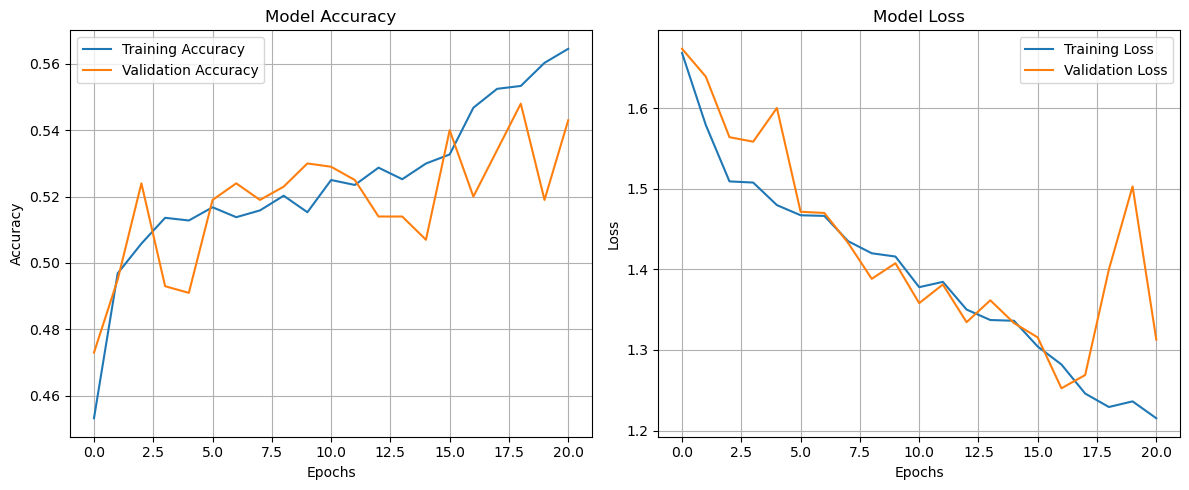

In [19]:
plot_training_history(history)

In [20]:
history = train_with_transformation(X_train_images, y_train_multiclass, X_val_images, y_val_multiclass, transformation_name=adjust_contrast,transformation_label='adjust_contrast', factor=-0.6)

Epoch 1/50
101/101 [==============================] - 65s 635ms/step - loss: 1.7550 - accuracy: 0.4340 - val_loss: 1.8865 - val_accuracy: 0.4280
Epoch 2/50
101/101 [==============================] - 64s 627ms/step - loss: 1.6621 - accuracy: 0.4433 - val_loss: 1.8407 - val_accuracy: 0.4100
Epoch 3/50
101/101 [==============================] - 63s 624ms/step - loss: 1.6125 - accuracy: 0.4770 - val_loss: 1.8181 - val_accuracy: 0.4000
Epoch 4/50
101/101 [==============================] - 63s 623ms/step - loss: 1.6141 - accuracy: 0.4785 - val_loss: 1.6013 - val_accuracy: 0.4910
Epoch 5/50
101/101 [==============================] - 63s 621ms/step - loss: 1.5799 - accuracy: 0.4877 - val_loss: 1.7559 - val_accuracy: 0.4180
Epoch 6/50
101/101 [==============================] - 63s 625ms/step - loss: 1.5587 - accuracy: 0.4919 - val_loss: 1.6746 - val_accuracy: 0.4490
Epoch 7/50
101/101 [==============================] - 63s 620ms/step - loss: 1.5338 - accuracy: 0.5009 - val_loss: 1.5559 - val_ac

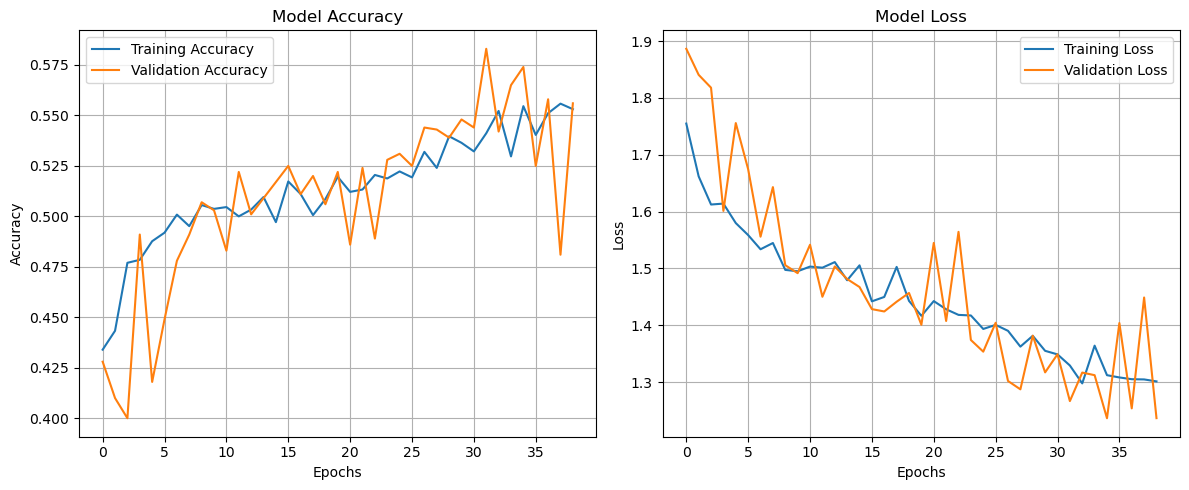

In [21]:
plot_training_history(history)

In [26]:
history = train_with_transformation(X_train_images, y_train_multiclass, X_val_images, y_val_multiclass, transformation_name=adjust_saturation, transformation_label='adjust_saturation', factor=10)

Epoch 1/50
101/101 [==============================] - 70s 669ms/step - loss: 1.6676 - accuracy: 0.4725 - val_loss: 1.8057 - val_accuracy: 0.5030
Epoch 2/50
101/101 [==============================] - 70s 691ms/step - loss: 1.5289 - accuracy: 0.5108 - val_loss: 1.6455 - val_accuracy: 0.5230
Epoch 3/50
101/101 [==============================] - 72s 709ms/step - loss: 1.4978 - accuracy: 0.5141 - val_loss: 1.4399 - val_accuracy: 0.5310
Epoch 4/50
101/101 [==============================] - 72s 713ms/step - loss: 1.4657 - accuracy: 0.5190 - val_loss: 1.5141 - val_accuracy: 0.5210
Epoch 5/50
101/101 [==============================] - 72s 710ms/step - loss: 1.4439 - accuracy: 0.5280 - val_loss: 1.4215 - val_accuracy: 0.5400
Epoch 6/50
101/101 [==============================] - 72s 714ms/step - loss: 1.4195 - accuracy: 0.5367 - val_loss: 1.3775 - val_accuracy: 0.5490
Epoch 7/50
101/101 [==============================] - 73s 717ms/step - loss: 1.4012 - accuracy: 0.5454 - val_loss: 1.4149 - val_ac

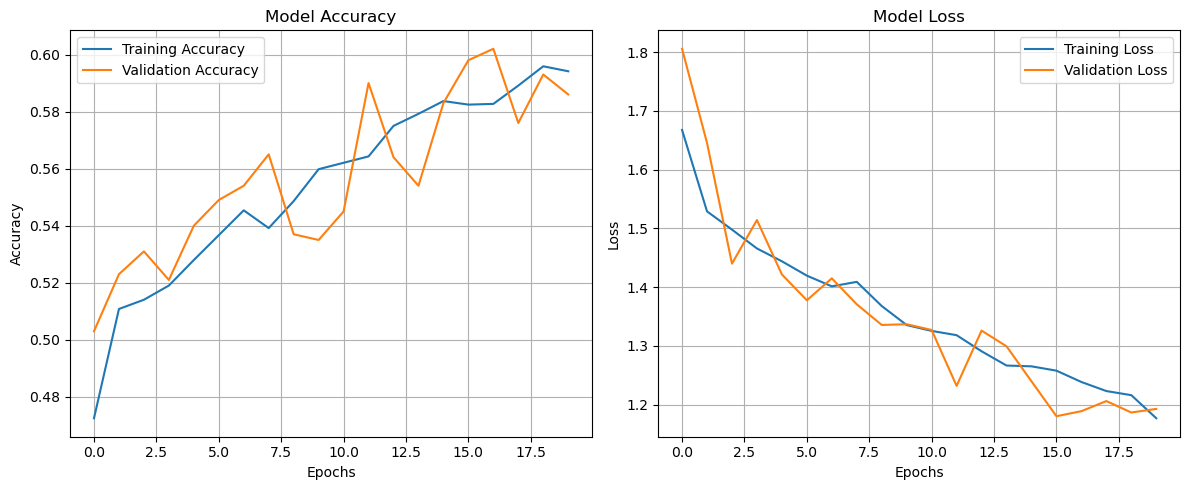

In [27]:
plot_training_history(history)

In [28]:
history = train_with_transformation(X_train_images, y_train_multiclass, X_val_images, y_val_multiclass, transformation_name=add_noise, transformation_label='add_noise', std=0.2)

Epoch 1/50
101/101 [==============================] - 70s 675ms/step - loss: 1.7310 - accuracy: 0.4404 - val_loss: 1.7283 - val_accuracy: 0.3920
Epoch 2/50
101/101 [==============================] - 67s 665ms/step - loss: 1.5702 - accuracy: 0.4998 - val_loss: 1.8029 - val_accuracy: 0.4180
Epoch 3/50
101/101 [==============================] - 68s 669ms/step - loss: 1.5653 - accuracy: 0.4956 - val_loss: 1.6273 - val_accuracy: 0.4740
Epoch 4/50
101/101 [==============================] - 68s 676ms/step - loss: 1.5299 - accuracy: 0.5042 - val_loss: 1.9129 - val_accuracy: 0.4130
Epoch 5/50
101/101 [==============================] - 68s 669ms/step - loss: 1.5183 - accuracy: 0.5116 - val_loss: 2.0909 - val_accuracy: 0.3570
Epoch 6/50
101/101 [==============================] - 69s 684ms/step - loss: 1.5161 - accuracy: 0.5073 - val_loss: 1.7634 - val_accuracy: 0.4250
Epoch 7/50
101/101 [==============================] - 73s 716ms/step - loss: 1.5157 - accuracy: 0.5044 - val_loss: 1.6668 - val_ac

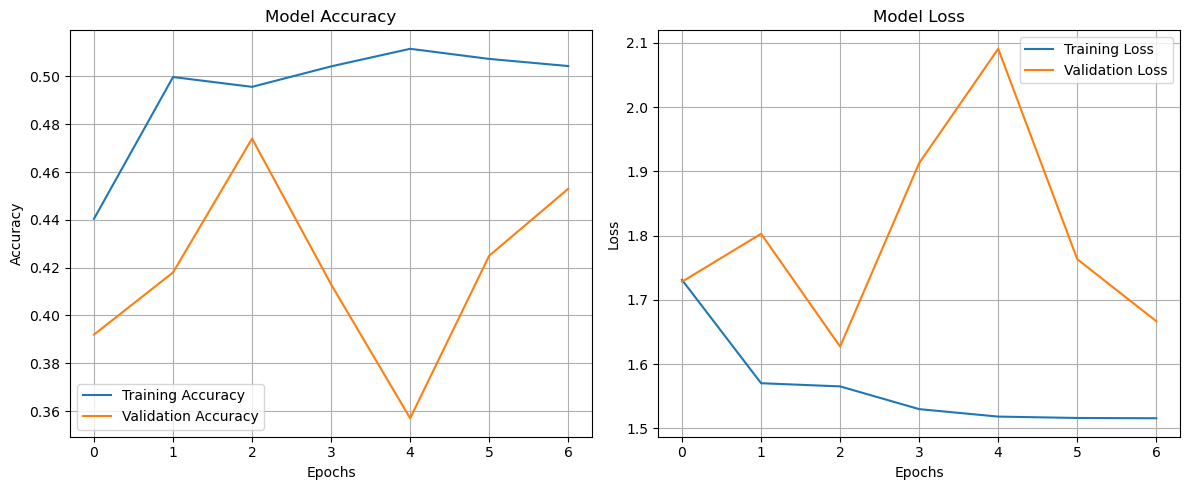

In [29]:
plot_training_history(history)

Among the transformations tested, the best results were achieved when we adjusted the saturation.

# Adjust Class Weights

In this part of the code, we address class imbalance by assigning weights to each class. This approach ensures that the model pays appropriate attention to underrepresented classes without altering the dataset size.


In [18]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_multiclass), y=y_train_multiclass)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 2.2275528169014085,
 1: 0.2865149456521739,
 2: 0.974768875192604,
 3: 1.5776184538653366,
 4: 1.2477810650887573,
 5: 1.767108938547486,
 6: 2.1814655172413793,
 7: 1.7379807692307692}

In [19]:
history_class_weights = train_with_transformation(X_train_images, y_train_multiclass, X_val_images, y_val_multiclass, transformation_name=adjust_saturation, transformation_label='class_weights', class_weights=class_weights_dict,  factor=10) 

Epoch 1/50
101/101 [==============================] - 85s 808ms/step - loss: 2.0049 - accuracy: 0.1614 - val_loss: 1.8920 - val_accuracy: 0.1330
Epoch 2/50
101/101 [==============================] - 72s 710ms/step - loss: 1.8627 - accuracy: 0.2495 - val_loss: 1.7690 - val_accuracy: 0.1290
Epoch 3/50
101/101 [==============================] - 72s 710ms/step - loss: 1.8276 - accuracy: 0.3027 - val_loss: 1.7759 - val_accuracy: 0.1660
Epoch 4/50
101/101 [==============================] - 72s 707ms/step - loss: 1.8039 - accuracy: 0.2987 - val_loss: 1.6913 - val_accuracy: 0.4870
Epoch 5/50
101/101 [==============================] - 71s 703ms/step - loss: 1.7843 - accuracy: 0.2885 - val_loss: 1.6950 - val_accuracy: 0.4880
Epoch 6/50
101/101 [==============================] - 73s 722ms/step - loss: 1.7643 - accuracy: 0.3571 - val_loss: 1.6713 - val_accuracy: 0.1730
Epoch 7/50
101/101 [==============================] - 73s 720ms/step - loss: 1.7157 - accuracy: 0.3049 - val_loss: 1.6314 - val_ac

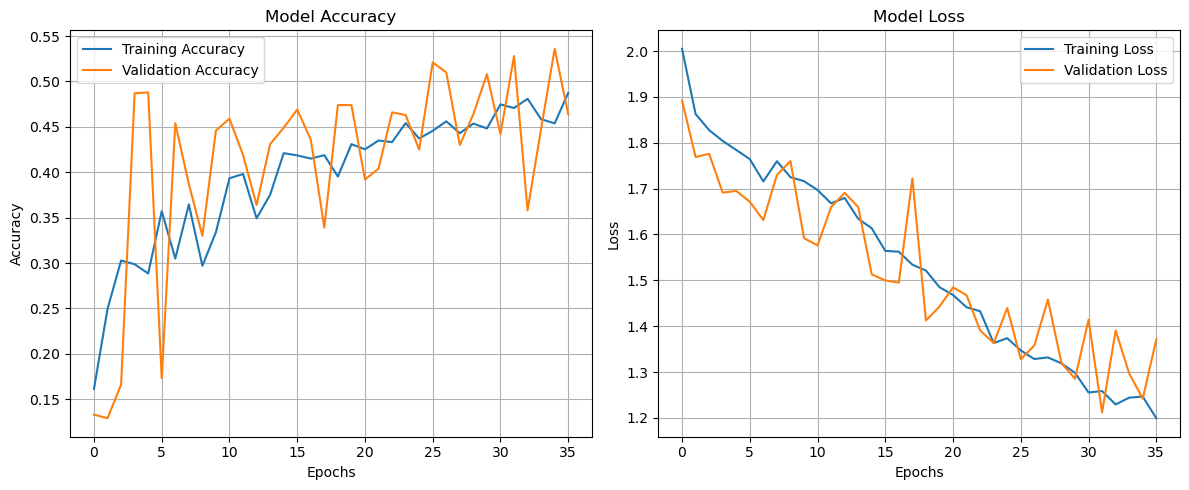

In [20]:
plot_training_history(history_class_weights)

Since we achieved better results with other models, we will not be using class weights.

# Hyperband Search

We know we probably should have started with Hyperband Search, as it’s an efficient and systematic way to find the best hyperparameters. However, we wanted to delay using it and explore other approaches first. Since none of the models we tried so far have achieved acceptable performance, it’s time to turn to Hyperband Search to optimize our model.

In [13]:
# Set up the Hyperband tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=25,
    factor=3,
    directory='./hyperband_results',
    project_name='conv_layers_tuning'
)

# Perform the search
tuner.search(
    X_train_images, y_train_multiclass,
    epochs=25,
    validation_data=(X_val_images, y_val_multiclass),
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Number of Conv Layers: {best_hps.get('num_conv_layers')}
- Filters and Kernel Sizes: {[best_hps.get(f'filters_{i}') for i in range(best_hps.get('num_conv_layers'))]},
  {[best_hps.get(f'kernel_size_{i}') for i in range(best_hps.get('num_conv_layers'))]}
- Dense Units: {best_hps.get('dense_units')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 30 Complete [01h 38m 51s]
val_accuracy: 0.590837299823761

Best val_accuracy So Far: 0.5955766439437866
Total elapsed time: 13h 36m 55s

Best Hyperparameters:
- Number of Conv Layers: 3
- Filters and Kernel Sizes: [32, 96, 128],
  [3, 5, 5]
- Dense Units: 160
- Learning Rate: 0.0001



In [14]:
# Train the final model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_images, y_train_multiclass, validation_data=(X_val_images, y_val_multiclass), epochs=30, callbacks=[early_stopping])

Epoch 1/30
159/159 [==============================] - 150s 938ms/step - loss: 1.6545 - accuracy: 0.4543 - val_loss: 1.5687 - val_accuracy: 0.5063
Epoch 2/30
159/159 [==============================] - 148s 932ms/step - loss: 1.4864 - accuracy: 0.4971 - val_loss: 1.4894 - val_accuracy: 0.4818
Epoch 3/30
159/159 [==============================] - 151s 952ms/step - loss: 1.4216 - accuracy: 0.5096 - val_loss: 1.3598 - val_accuracy: 0.5158
Epoch 4/30
159/159 [==============================] - 151s 948ms/step - loss: 1.3668 - accuracy: 0.5159 - val_loss: 1.3779 - val_accuracy: 0.5158
Epoch 5/30
159/159 [==============================] - 147s 925ms/step - loss: 1.3439 - accuracy: 0.5236 - val_loss: 1.3183 - val_accuracy: 0.5371
Epoch 6/30
159/159 [==============================] - 144s 905ms/step - loss: 1.3240 - accuracy: 0.5291 - val_loss: 1.2936 - val_accuracy: 0.5340
Epoch 7/30
159/159 [==============================] - 146s 920ms/step - loss: 1.2765 - accuracy: 0.5426 - val_loss: 1.3247 -

In [15]:
model.save('saved_models/hyperband_model.h5')

Let's try the model architecture but now with dropout to prevent overfit.

In [34]:
model_hyper = Sequential()
    
model_hyper.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(150,150,3)))
model_hyper.add(MaxPooling2D(pool_size=2))
model_hyper.add(Dropout(0.3))

model_hyper.add(Conv2D(filters=96, kernel_size=5, activation='relu'))
model_hyper.add(MaxPooling2D(pool_size=2))
model_hyper.add(Dropout(0.2))

model_hyper.add(Conv2D(filters=128, kernel_size=5, activation='relu'))
model_hyper.add(MaxPooling2D(pool_size=2))

model_hyper.add(Flatten())

model_hyper.add(Dense(units=160, activation='relu'))
model_hyper.add(Dropout(0.2))

model_hyper.add(Dense(8, activation='softmax'))

model_hyper.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

In [35]:
# Train the model 
history_hyper = model_hyper.fit(
    X_train_images,
    y_train_multiclass,
    validation_data=(X_val_images, y_val_multiclass),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
159/159 [==============================] - 172s 1s/step - loss: 1.6345 - accuracy: 0.4778 - val_loss: 1.7759 - val_accuracy: 0.5024
Epoch 2/30
159/159 [==============================] - 177s 1s/step - loss: 1.5549 - accuracy: 0.5003 - val_loss: 1.6563 - val_accuracy: 0.5024
Epoch 3/30
159/159 [==============================] - 180s 1s/step - loss: 1.5003 - accuracy: 0.5054 - val_loss: 1.5514 - val_accuracy: 0.5118
Epoch 4/30
159/159 [==============================] - 182s 1s/step - loss: 1.4355 - accuracy: 0.5046 - val_loss: 1.5530 - val_accuracy: 0.5150
Epoch 5/30
159/159 [==============================] - 180s 1s/step - loss: 1.3985 - accuracy: 0.5100 - val_loss: 1.4901 - val_accuracy: 0.5419
Epoch 6/30
159/159 [==============================] - 178s 1s/step - loss: 1.3733 - accuracy: 0.5185 - val_loss: 1.4348 - val_accuracy: 0.5348
Epoch 7/30
159/159 [==============================] - 182s 1s/step - loss: 1.3313 - accuracy: 0.5301 - val_loss: 1.4406 - val_accuracy: 0.5237

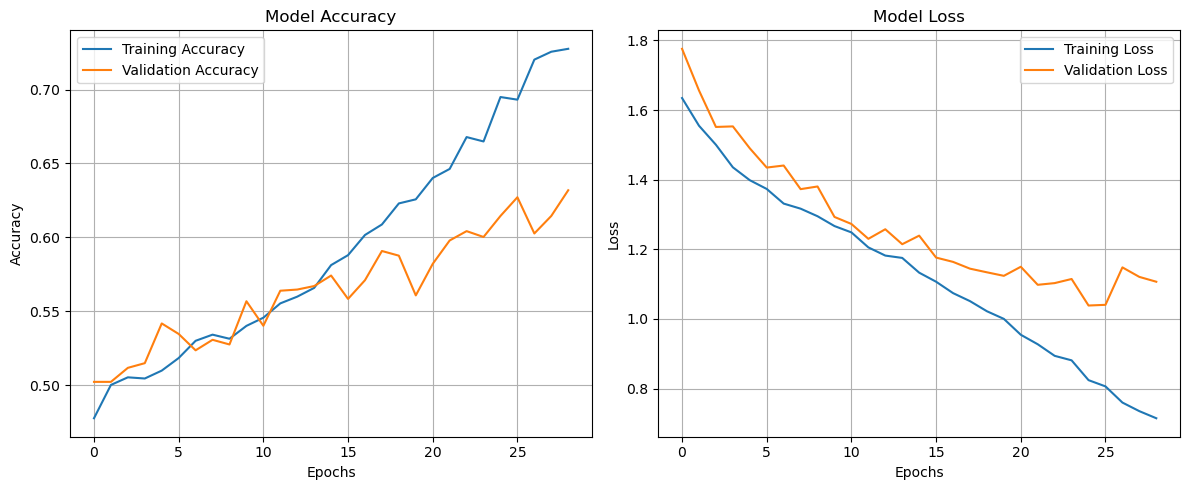

In [36]:
plot_training_history(history_hyper)

In [37]:
model_hyper.save('saved_models/model_hyper.h5')

# Evaluation of best 2 models

Despite their overall poor performance, the models with adjusted saturation and the one using HyperBand Search architecture with dropout are the best we’ve achieved so far. We will now test them on the test set.

In [44]:
model_saturation = load_model('saved_models\model_adjust_saturation.h5')

In [47]:
# Make predictions on the test set
y_pred1 = model_saturation.predict(X_test_images)

# Convert the predictions to class labels based on the threshold
y_pred_classes1 = np.argmax(y_pred1, axis=-1)

# Print the classification report for Model with adjusted saturation
print("Classification Report for Model with adjusted saturation:")
print(classification_report(y_test_multiclass, y_pred_classes1, target_names=['Adenosis', 'Ductal Carcinoma', 'Fibroadenoma',
       'Lobular Carcinoma', 'Mucinous Carcinoma', 'Papillary Carcinoma',
       'Phyllodes Tumor', 'Tubular Adenoma']))

50/50 [==============================] - 4s 69ms/step
Classification Report for Model with adjusted saturation:
                     precision    recall  f1-score   support

           Adenosis       0.00      0.00      0.00        89
   Ductal Carcinoma       0.45      0.94      0.61       690
       Fibroadenoma       0.00      0.00      0.00       203
  Lobular Carcinoma       0.00      0.00      0.00       125
 Mucinous Carcinoma       0.05      0.04      0.04       158
Papillary Carcinoma       0.00      0.00      0.00       112
    Phyllodes Tumor       0.00      0.00      0.00        91
    Tubular Adenoma       0.78      0.06      0.11       114

           accuracy                           0.42      1582
          macro avg       0.16      0.13      0.10      1582
       weighted avg       0.26      0.42      0.28      1582



c:\Users\User\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
model_hyper = load_model('saved_models\model_hyper.h5')

In [48]:
# Make predictions on the test set
y_pred1 = model_hyper.predict(X_test_images)

# Convert the predictions to class labels based on the threshold
y_pred_classes1 = np.argmax(y_pred1, axis=-1)

# Print the classification report for Model with HyperBand Search
print("Classification Report for Model with HyperBand Search:")
print(classification_report(y_test_multiclass, y_pred_classes1, target_names=['Adenosis', 'Ductal Carcinoma', 'Fibroadenoma',
       'Lobular Carcinoma', 'Mucinous Carcinoma', 'Papillary Carcinoma',
       'Phyllodes Tumor', 'Tubular Adenoma']))


50/50 [==============================] - 15s 300ms/step
Classification Report for Model with HyperBand Search:
                     precision    recall  f1-score   support

           Adenosis       0.64      0.52      0.57        89
   Ductal Carcinoma       0.69      0.88      0.78       690
       Fibroadenoma       0.49      0.63      0.55       203
  Lobular Carcinoma       0.57      0.30      0.39       125
 Mucinous Carcinoma       0.42      0.34      0.37       158
Papillary Carcinoma       0.44      0.16      0.24       112
    Phyllodes Tumor       0.43      0.24      0.31        91
    Tubular Adenoma       0.58      0.46      0.51       114

           accuracy                           0.61      1582
          macro avg       0.53      0.44      0.47      1582
       weighted avg       0.59      0.61      0.58      1582



The model with HyperBand Search significantly outperforms the one with adjusted saturation. While the saturation-adjusted model achieves only 42% accuracy and struggles with most classes (weighted avg F1-score: 28%), the HyperBand Search model improves to 61% accuracy, with a weighted avg F1-score of 58%. The latter demonstrates better performance across classes, notably achieving an F1-score of 57% for Adenosis and 55% for Fibroadenoma, compared to 0% in the first model. However, challenges remain for minority classes like Papillary Carcinoma and Phyllodes Tumor, which still exhibit low F1-scores. Overall, HyperBand Search produces a more balanced model. Despite the improvements, neither model is suitable for real-world implementation due to their limited overall accuracy, inconsistent performance across classes, and inability to handle minority classes effectively.